In [1]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [148]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_input_csv():
    df = pd.read_csv('./highcos-plagiarism_included.csv', sep=',')
    df1 = df[['essay']]
    df1_dict = df1.to_dict('dict')
    return df1, df1_dict
    
vectorize = lambda Text: TfidfVectorizer().fit_transform(Text).toarray()

similarity = lambda doc1, doc2: cosine_similarity([doc1, doc2])

In [3]:
df1, df1_dict = read_input_csv()

In [4]:
strList = [df1['essay'][0]]
vectors_0 = vectorize(strList)

strList = [df1['essay'][1]]
vectors_1 = vectorize(strList)

In [5]:
vectors_0

array([[0.21016277, 0.02627035, 0.02627035, 0.02627035, 0.02627035,
        0.10508139, 0.02627035, 0.02627035, 0.02627035, 0.05254069,
        0.02627035, 0.10508139, 0.02627035, 0.07881104, 0.05254069,
        0.02627035, 0.02627035, 0.02627035, 0.02627035, 0.02627035,
        0.05254069, 0.02627035, 0.02627035, 0.10508139, 0.02627035,
        0.13135173, 0.02627035, 0.02627035, 0.18389243, 0.05254069,
        0.02627035, 0.02627035, 0.02627035, 0.02627035, 0.05254069,
        0.02627035, 0.02627035, 0.02627035, 0.02627035, 0.02627035,
        0.05254069, 0.02627035, 0.02627035, 0.02627035, 0.02627035,
        0.02627035, 0.02627035, 0.02627035, 0.02627035, 0.13135173,
        0.02627035, 0.02627035, 0.02627035, 0.02627035, 0.02627035,
        0.05254069, 0.02627035, 0.05254069, 0.10508139, 0.02627035,
        0.02627035, 0.05254069, 0.05254069, 0.02627035, 0.02627035,
        0.07881104, 0.05254069, 0.10508139, 0.02627035, 0.05254069,
        0.13135173, 0.02627035, 0.13135173, 0.05

In [6]:
vectorList = [vectors_0,vectors_1]
cosine_similarity_score = 1. - cdist(vectors_0, vectors_1, 'cosine')



ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [7]:
x = np.random.rand(1000,1000)
x

array([[0.43438199, 0.94505365, 0.29136662, ..., 0.16681954, 0.08612824,
        0.84974977],
       [0.12415863, 0.85780316, 0.35289161, ..., 0.23046215, 0.19519337,
        0.08884654],
       [0.81195756, 0.29618257, 0.11927569, ..., 0.91647792, 0.65998238,
        0.34383615],
       ...,
       [0.07497086, 0.45645692, 0.33009484, ..., 0.35380658, 0.43076694,
        0.14800005],
       [0.94715578, 0.2047074 , 0.89041515, ..., 0.35603814, 0.2554036 ,
        0.97335926],
       [0.18606255, 0.92389021, 0.82581852, ..., 0.95567776, 0.87541477,
        0.93024864]])

# Fixing the Unequal Vectors Problem

* When we compare the cosine similarity between two essays, we are really comparing the cosine similarity between vectors. Cosine similarity can only be calculated on equal length vectors.
* The way that the MPNet fine-tuned language model, all-MiniLM-L6-v2 deals with this problem, is that input text gets truncated down to 256 words.
* If an input text were to be less than 256 words, then 0's need to be appended to the end of the vector.
* The original all-MiniLM-L6-v2 vector space was said to be 384 dimensional, so we could use the same dimensionality in either truncating or expanding the vectors if they are different from this length.

Note - the length equality restriction does not apply to the vectorization() function, but it does apply to the cosine_similarity function. Hence, we don't apply length similarity prior to vectorization to the text, but we do apply it to the vector produced by the text.

In [141]:
def read_input_csv():
    df = pd.read_csv('./highcos-plagiarism_included.csv', sep=',')
    df1 = df[['essay']]
    df1_dict = df1.to_dict('dict')
    return df1, df1_dict

def truncate_256word(df1_dict):
    truncated_dict = {}
    final_truncated_dict = {}
    for each in df1_dict['essay']:
        text = df1_dict['essay'][each]
        textTruncatedList = text.split()[0:256]
        textTruncated = " ".join(textTruncatedList)
        truncated_dict[each] = textTruncated
                    
    final_truncated_dict['essay']=truncated_dict
         
    return final_truncated_dict

def vectorize_corpus(truncatedDict):
    # get entire corpus into list
    corpus = []
    for text in truncatedDict['essay']:
        corpus.append(truncatedDict['essay'][text])

    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(corpus)
    
    featureNames = vectorizer.get_feature_names_out()
    
    return vectors, featureNames

def check_length(vectorDict):
    count=0
    for item in vectorDict['essay']:
        if len(vectorDict['essay'][item]) != 384:
            print("Essay at: ",item," has length: ",len(vectorDict['essay'][item]))
            count = count+1
    
    if count == 0:
        print("All essays length 384")
        
# cosine similarity of all sentence embeddings against each other, put into dataframe
def create_embedding_cosine_matrix(vectors):
    # setup empty dataframe
    df_cosine_sim = pd.DataFrame()
    df_cosine_sim

    # setup empty meas_dict
    meas_dict = {}
    
    # setup key sizes
    essayNum = vectors.get_shape()[0]

    for key in range(0,essayNum):
        # compare to every other essay except self
        i=0
        for item in range(0,essayNum):
            if key == item:
                meas_dict[i] = 1
                i=i+1
            else:
                meas = 1. - cdist(vectors[key].toarray(), vectors[item].toarray(), 'cosine')
                meas_dict[i] = meas.item()
                i=i+1

        # show dict status
        df_cosine_sim_col = pd.DataFrame.from_dict(meas_dict,orient='index')
        df_cosine_sim_col.columns = [key]
        # print(df_cosine_sim_col)
        df_cosine_sim = pd.concat([df_cosine_sim, df_cosine_sim_col], axis=1)
        
    return df_cosine_sim

In [142]:
df1, df1_dict = read_input_csv()
truncatedDict = truncate_256word(df1_dict)
vectors, featureNames = vectorize_corpus(truncatedDict)
vectorDict = vectorize_384dim(truncatedDict)
check_length(vectorDict)
df_cosine_sim = create_embedding_cosine_matrix(vectors)

All essays length 384


In [143]:
df_cosine_sim

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,1.000000,0.220740,0.270220,0.307712,0.213553,0.325168,0.279354,0.289230,0.318665,0.287163,...,0.264242,0.301551,0.243686,0.323043,0.307158,0.278896,0.300378,0.250448,1.000000,0.859747
1,0.220740,1.000000,0.236915,0.254891,0.255488,0.270092,0.225909,0.253804,0.265400,0.325436,...,0.242296,0.233837,0.260560,0.296026,0.429818,0.306662,0.259275,0.312415,0.220740,0.228945
2,0.270220,0.236915,1.000000,0.255600,0.201488,0.221122,0.281649,0.255942,0.295325,0.230885,...,0.287668,0.209424,0.258908,0.276373,0.344731,0.278555,0.236307,0.258299,0.270220,0.270391
3,0.307712,0.254891,0.255600,1.000000,0.320459,0.303209,0.306077,0.258649,0.344322,0.320135,...,0.286288,0.300241,0.293698,0.376071,0.353182,0.301680,0.344671,0.309315,0.307712,0.319327
4,0.213553,0.255488,0.201488,0.320459,1.000000,0.294572,0.218324,0.270097,0.304900,0.284351,...,0.261740,0.231209,0.216147,0.328861,0.309873,0.281925,0.218813,0.260989,0.213553,0.244831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.278896,0.306662,0.278555,0.301680,0.281925,0.323859,0.246601,0.253608,0.297234,0.310107,...,0.283580,0.290164,0.249758,0.316609,0.346912,1.000000,0.273280,0.334463,0.278896,0.271142
110,0.300378,0.259275,0.236307,0.344671,0.218813,0.280870,0.297652,0.306034,0.250556,0.286464,...,0.237759,0.280615,0.286612,0.324274,0.331778,0.273280,1.000000,0.281019,0.300378,0.309267
111,0.250448,0.312415,0.258299,0.309315,0.260989,0.298736,0.266590,0.247140,0.304255,0.283703,...,0.262525,0.255793,0.280150,0.336305,0.344815,0.334463,0.281019,1.000000,0.250448,0.279100
112,1.000000,0.220740,0.270220,0.307712,0.213553,0.325168,0.279354,0.289230,0.318665,0.287163,...,0.264242,0.301551,0.243686,0.323043,0.307158,0.278896,0.300378,0.250448,1.000000,0.859747


In [158]:
def walkthrough_nomatch_counts(df_cosine_sim):
    numcols = df_cosine_sim.shape[1]
    numrows = df_cosine_sim.shape[0]
    df_nomatch = pd.DataFrame(index=range(numrows),columns=range(numcols)) 
    for col in range(0,numcols):
        for row in range(0,numrows):
            if col == row:
                df_nomatch[col][row] = np.nan
            elif col > row:
                df_nomatch[col][row] = np.nan
            elif col < row:
                df_nomatch[col][row] = df_cosine_sim[col][row]

    return df_nomatch

def get_stats_report(df_nomatch):
    get_plots(df_nomatch)
    get_meanmedvar(df_nomatch)
    
def get_plots(df_nomatch):
    nplotcols = 1
    nplotrows = 1
    fig1, axes1 = plt.subplots(nrows=nplotrows, ncols=nplotcols, figsize=(10, 10))
    plt.xlim([-0.1,1.1]) 
    histplot = df_nomatch.stack().hist(bins=100)
    fig2, axes2 = plt.subplots(nrows=nplotrows, ncols=nplotcols, figsize=(10, 10))
    plt.xlim([-0.1,1.1]) 
    distplot = df_nomatch.stack().plot.kde()
    
def get_meanmedvar(df_nomatch):
    print("The mean of the cosine similarity is       : ",df_nomatch.stack().mean())
    print("The median of the cosine similarity is     : ",df_nomatch.stack().median())
    print("The variance of the cosine similarity is   : ",df_nomatch.stack().var())
    stack_stdev = df_nomatch.stack().std()
    print("The stdev of the stack is                  : ",df_nomatch.stack().std())
    threshold = 0.9
    print(threshold, " would be #'s of stdev's from mean     : ",(threshold-df_nomatch.stack().mean())/stack_stdev)

The mean of the cosine similarity is       :  0.2867084875311568
The median of the cosine similarity is     :  0.28300663215639055
The variance of the cosine similarity is   :  0.002890388709767656
The stdev of the stack is                  :  0.053762335419582134
0.9  would be #'s of stdev's from mean     :  11.407456682870604


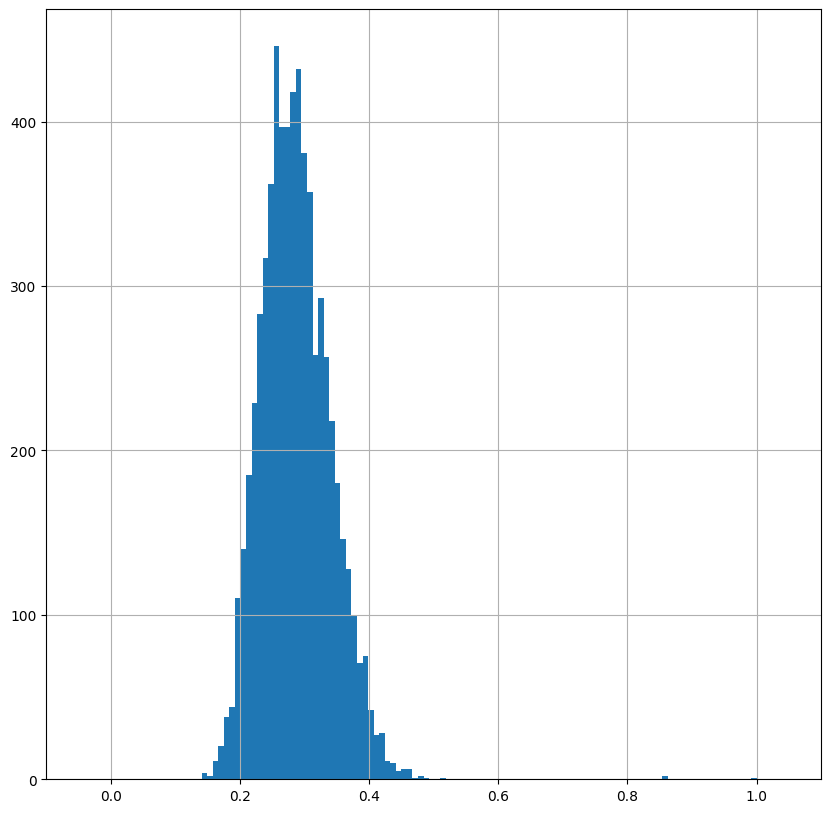

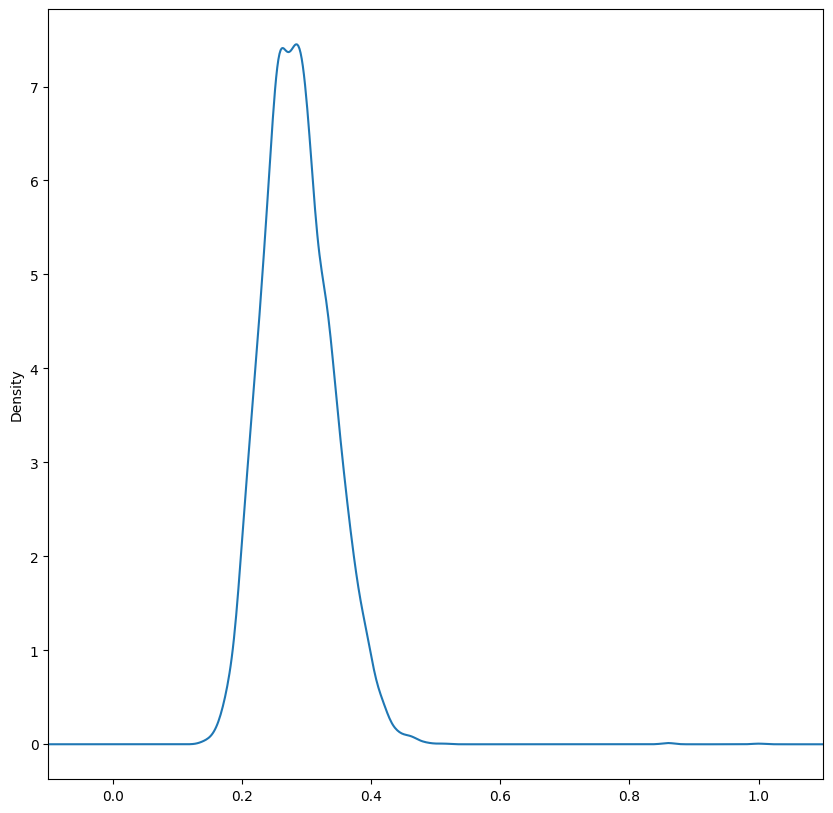

In [159]:
df_nomatch = walkthrough_nomatch_counts(df_cosine_sim)
get_stats_report(df_nomatch)

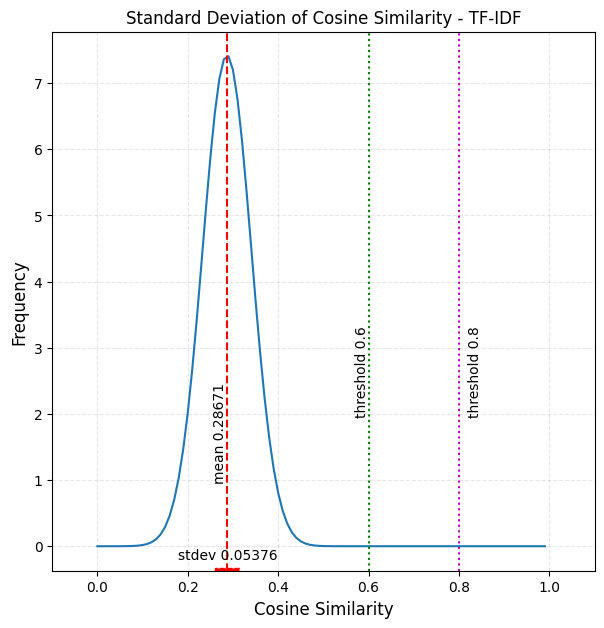

In [157]:
import scipy.stats as stats
from scipy.stats import norm

# Entering in the Mean and Stdev
df_mean = 0.2867084875311568
df_std = 0.053762335419582134

x_axis = np.arange(0, 1, 0.01)
 
# Calculating probability density function (PDF)
pdf = norm.pdf(x_axis, df_mean, df_std)

# Drawing a graph
fig = plt.figure(1, figsize=(7, 7))
ax = fig.add_subplot(111)
plt.plot(x_axis, pdf)
plt.xlim([-0.1,1.1])  
plt.xlabel("Cosine Similarity", size=12)    
plt.ylabel("Frequency", size=12)                
plt.grid(True, alpha=0.3, linestyle="--")
plt.axvline(x = df_mean,color='r',linestyle='dashed')
plt.axvspan(xmin = df_mean-df_std/2, xmax=df_mean+df_std/2,ymin=0,ymax=0.005,color='r',linestyle='dashed')

meanStr = "mean " + str(round(df_mean,5))
plt.text(df_mean-0.03,1,meanStr,rotation=90)
stdStr = "stdev " + str(round(df_std,5))
plt.text(df_mean-df_std*2,-0.2,stdStr,rotation=0)

threshold=0.6
plt.axvline(x = threshold,color='g',linestyle='dotted')
thresholdStr = "threshold " + str(threshold)
plt.text(threshold-0.03,2,thresholdStr,rotation=90)

offset=0.2
thresholdoffset = round(threshold+offset,2)
plt.axvline(x = thresholdoffset,color='m',linestyle='dotted')
thresholdStr = "threshold " + str(thresholdoffset)
plt.text(thresholdoffset+0.02,2,thresholdStr,rotation=90)


plt.title("Standard Deviation of Cosine Similarity - TF-IDF")
plt.show()